In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder

from IPython.display import clear_output

In [3]:
!pip install keras-tuner
!pip install tensorflow-addons

     |████████████████████████████████| 98 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_tuner as kt


In [6]:
# mount drive to save generated files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = '/content/drive/MyDrive/'
base_dir = root_dir + 'Music Genre/mfcc/'

Mounted at /content/drive


In [7]:
train_dir = base_dir + 'training/'
val_dir = base_dir + 'validation/'
test_dir = base_dir + 'test/'

metadata_dir = root_dir + 'Music Genre/fma/data/fma_metadata/'

In [8]:
tracks = pd.read_csv( metadata_dir + 'tracks.csv', index_col=0, header=[0, 1])

medium = tracks['set', 'subset'] == 'medium'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

data_train = tracks.loc[medium & train, ('track', 'genre_top')]
data_test = tracks.loc[medium & test, ('track', 'genre_top')]
data_val = tracks.loc[medium & val, ('track', 'genre_top')]

num_classes = np.unique(data_train).size
classes=np.array( np.unique(data_train) )

print('{} training examples, {} val examples, {} testing examples'.format(data_train.size, data_val.size, data_test.size))
print('{} classes: '.format(num_classes))
print( classes )

13522 training examples, 1705 val examples, 1773 testing examples
16 classes: 
['Blues' 'Classical' 'Country' 'Easy Listening' 'Electronic'
 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental' 'International' 'Jazz'
 'Old-Time / Historic' 'Pop' 'Rock' 'Soul-RnB' 'Spoken']


In [9]:
print(data_train.head())

track_id
3      Hip-Hop
134    Hip-Hop
136       Rock
139       Folk
198       Folk
Name: (track, genre_top), dtype: object


(39, 2580)


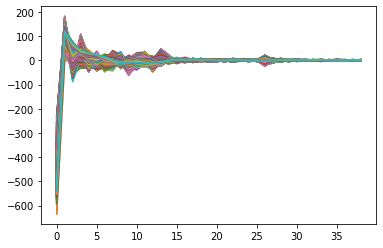

In [10]:
from PIL import Image

im = Image.open(train_dir + 'blues/004_004537.tif') 
#im.show()

imarray = np.array(im) 
print( imarray.shape )

plt.plot(imarray)
plt.show()

In [18]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

batch_size = 64
epochs = 3

input_shape = (39, 2580, 1)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(input_shape[0], input_shape[1]),
        color_mode= "grayscale",
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(input_shape[0], input_shape[1]),
        color_mode= "grayscale",
        batch_size=batch_size,
        class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(input_shape[0], input_shape[1]),
        color_mode= "grayscale",
        batch_size=batch_size,
        class_mode='sparse')

Found 19903 images belonging to 16 classes.
Found 2504 images belonging to 16 classes.
Found 2572 images belonging to 16 classes.


In [20]:
precision_function = tf.keras.metrics.Precision()
recall_function = tf.keras.metrics.Recall()
auc_function = tf.keras.metrics.AUC()
f1_function = tfa.metrics.F1Score(num_classes=num_classes, average='micro')

def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=input_shape))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(num_classes))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy", f1_function])

  return model

In [27]:
precision_function = tf.keras.metrics.Precision()
recall_function = tf.keras.metrics.Recall()
auc_function = tf.keras.metrics.AUC()
f1_function = tfa.metrics.F1Score(num_classes=num_classes, average='micro')

def build_model(hp):
    inputs = keras.Input(shape=input_shape)

    x = inputs
    # Number of layers of the CNN is also a hyperparameter.
    for i in range(hp.Int("cnn_layers", 1, 5)):
        x = layers.Conv2D(
            hp.Int(f"filters_{i}", 4, 128, step=32),
            kernel_size=(3, 3),
            activation="relu",
        )(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)

    # A hyperparamter for whether to use dropout layer.
    if hp.Boolean("dropout"):
        x = layers.Dropout(hp.Choice('dropout_value', values=[0.1, 0.25, 0.5]))(x)

    # The last layer contains the output units,
    # which is the same as the number of classes.
    outputs = layers.Dense(units=num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model.
    model.compile(
        loss="sparse_categorical_crossentropy", 
        metrics=["accuracy", f1_function], 
        optimizer="adam",
    )
    return model


In [28]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=root_dir+'Music Genre/save')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Music Genre/save/untitled_project/oracle.json


In [29]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_generator, epochs=50, validation_data=validation_generator, callbacks=[stop_early])
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
units             |480               |?                 
learning_rate     |0.01              |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |2                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2
242/311 [======================>.......] - ETA: 17:22 - loss: 1609.1615 - accuracy: 0.2632 - f1_score: 0.1240

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_generator, epochs=50, validation_data=validation_generator)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
network_history = hypermodel.fit(train_generator, epochs=best_epoch, validation_data=validation_generator)

In [ ]:
hypermodel.summary()

In [ ]:
eval_result = hypermodel.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
from matplotlib import pyplot as plt
x_plot = list(range(1,epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [ ]:
plot_history(network_history)

In [ ]:
test_pred = model.predict(test_generator)

In [ ]:
y_pred = []
for pred in test_pred:
  y_pred.append( np.argmax(pred) )

In [ ]:
from sklearn.metrics import f1_score

y_true = test_generator.labels

f1_test = f1_score(y_true, y_pred, average='macro')
print('Average f1_score: {} \n' .format(f1_test) )

print('F1-SCORE FOR EACH CLASS')
print('-----------------------')
av_f1_score = f1_score(y_true, y_pred, average=None)
for i in range(len(av_f1_score)):
  print('{} : {} '.format(classes[i], av_f1_score[i]))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay( confusion_matrix=cm, 
                              display_labels=classes)

disp.plot()
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
plt.show()